In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 
from datetime import datetime, timedelta, timezone
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Introduction

This notebook is done as party of the project in the course.... The aim is to predict the total electric consumption of France (in MW) on the 8th of December using time series data gathered from : https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/information/

# Data preparation

In [3]:
# Importing data 
data=pd.read_csv("eco2mix-national-tr.csv", sep=";")

In [4]:
# Insights on data
## Number of samples
print(f"Number of samples is {data.count()[0]}")
## Head of dataframe
data.head()

Number of samples is 17664


,Périmètre,Nature,Date,Heure,Date - Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW),Stockage batterie (MW),Déstockage batterie (MW),Eolien terrestre (MW),Eolien offshore (MW)
0,France,Données temps réel,2022-06-01,00:00,2022-06-01T10:00:00+12:00,44940.0,44800.0,45100.0,144.0,0.0,...,4331.0,1054.0,1677.0,170.0,584.0,286.0,ND,ND,ND,ND
1,France,Données temps réel,2022-06-01,02:15,2022-06-01T12:15:00+12:00,39778.0,39450.0,39600.0,143.0,6.0,...,4053.0,840.0,272.0,176.0,564.0,276.0,ND,ND,ND,ND
2,France,Données temps réel,2022-06-01,05:15,2022-06-01T15:15:00+12:00,37506.0,37150.0,37200.0,144.0,7.0,...,3851.0,610.0,226.0,159.0,562.0,276.0,ND,ND,ND,ND
3,France,Données temps réel,2022-06-01,07:15,2022-06-01T17:15:00+12:00,44259.0,44650.0,44150.0,144.0,10.0,...,4506.0,1302.0,855.0,163.0,568.0,276.0,ND,ND,ND,ND
4,France,Données temps réel,2022-06-01,07:30,2022-06-01T17:30:00+12:00,45062.0,45700.0,45100.0,144.0,10.0,...,4522.0,1314.0,984.0,160.0,568.0,276.0,ND,ND,ND,ND


### Data cleaning

Remove unnecessary columns

In [5]:
# Some columns contain missing values or are irrelevant (same value everywhere)
print(data["Eolien terrestre (MW)"].value_counts())
print(data["Stockage batterie (MW)"].value_counts()) 
print(data["Périmètre"].value_counts()) 

ND    17528
Name: Eolien terrestre (MW), dtype: int64
ND    17528
Name: Stockage batterie (MW), dtype: int64
France    17664
Name: Périmètre, dtype: int64


In [6]:
# Remove the unnecessary columns
columns_to_drop=["Périmètre","Nature","Prévision J-1 (MW)","Prévision J (MW)", "Stockage batterie (MW)", "Déstockage batterie (MW)", "Eolien terrestre (MW)", "Eolien offshore (MW)"]
data.drop(columns=columns_to_drop, inplace= True)

In [7]:
# Remove duplicate values 
data.drop_duplicates(subset=["Date - Heure"], inplace=True)

In [9]:
# Remove rows containg empty values
data.dropna(subset=["Date - Heure", "Consommation (MW)"], inplace = True)
print(f"Number of samples is {data.count()[0]}")

Number of samples is 17528


### Data reformatting

In [10]:
# Converting date column to datetime format and set time column as index
data['Time'] = data[['Date', 'Heure']].agg(' '.join, axis=1)
data["Time"]=pd.to_datetime(data["Time"])
data["Date"]= pd.to_datetime(data["Date"])
data["Heure"]=pd.to_datetime(data["Heure"])
data.set_index("Time", inplace=True)
data.drop(columns=["Date - Heure"], inplace= True)

In [11]:
# Sorting data chronologically
data=data.sort_index(ascending=True)

In [15]:
data=data.loc[data['Date'] >= '2022-09-24']

In [16]:
data.count()

Date                                         6488
Heure                                        6488
Consommation (MW)                            6488
Fioul (MW)                                   6488
Charbon (MW)                                 6488
Gaz (MW)                                     6488
Nucléaire (MW)                               6488
Eolien (MW)                                  6488
Solaire (MW)                                 6488
Hydraulique (MW)                             6488
Pompage (MW)                                 6488
Bioénergies (MW)                             6488
Ech. physiques (MW)                          6488
Taux de CO2 (g/kWh)                          6488
Ech. comm. Angleterre (MW)                   3244
Ech. comm. Espagne (MW)                      3244
Ech. comm. Italie (MW)                       3244
Ech. comm. Suisse (MW)                       3244
Ech. comm. Allemagne-Belgique (MW)           3244
Fioul - TAC (MW)                             6488


### Data vizualization

<AxesSubplot:>

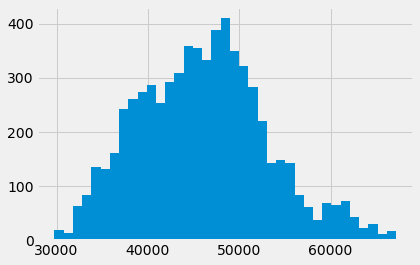

In [17]:
# Plotting the distribution of Consommation (MW)
data["Consommation (MW)"].hist(bins='auto')

Text(0.5, 1.0, 'Electricity consumption over time')

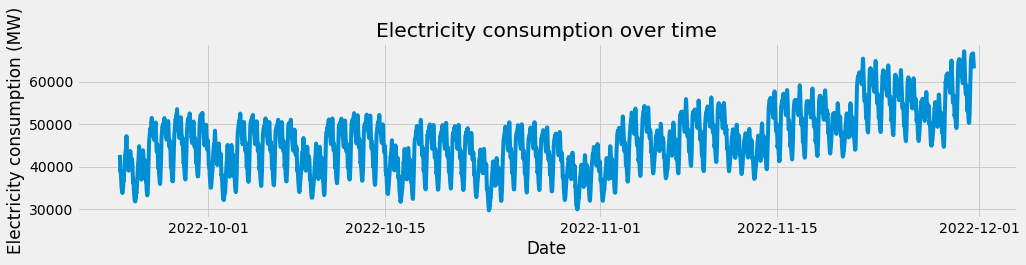

In [18]:
# Plotting the distribution of Consommation (MW)
plt.figure(figsize=(15, 3))
plt.plot(data["Consommation (MW)"],label='Consommation')
plt.xlabel("Date")
plt.ylabel("Electricity consumption (MW)")
plt.title("Electricity consumption over time")

Since we'll try to predict the electricity consumption within a single day, we can keep only recent observations (5 weeks).

# Prediction

In this section, we'll predict the total consumption. 

### Time Series analysis

Let's vizualize the trend, seasonality and residuals of our data

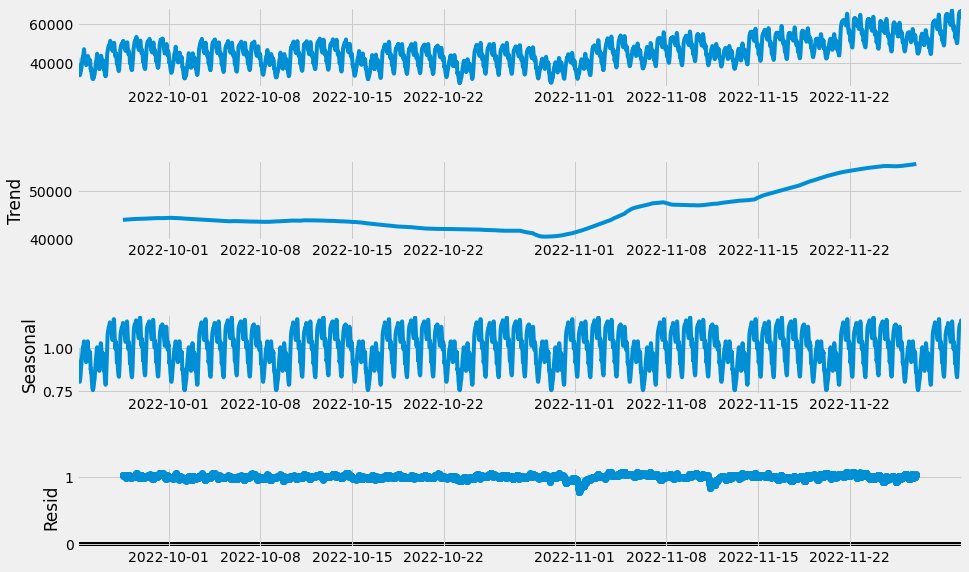

In [19]:
# We set period to the equivalent of 1 week time (672 samples of 15 min)
result = seasonal_decompose(data[["Consommation (MW)"]], model='multiplicative', period=672)
fig=result.plot()
fig.set_size_inches((16, 9))
plt.show()

The time series doesn't look stationary : trend isn't constant and we can see on the seasonality curve that there seems to be a recurrent event (maximum electricity consumption) that occurs each day. Time series forecasting models recquire stationary time series, therefore, we need to stationarize the time series. 

#### Stationarizing time series

To stationarize the time series, we'll perform a series of modifications to data. In order to check if data is stationary after each step, we define a function to check the stationarity of the timeseries. This section is inspired by https://www.kdnuggets.com/2020/01/predict-electricity-consumption-time-series-analysis.html?fbclid=IwAR3dsh8lns15V35FM-3TkE8tQADtpdbqO6q9uUZfEd6ksLNMyuv3_vv8deg.

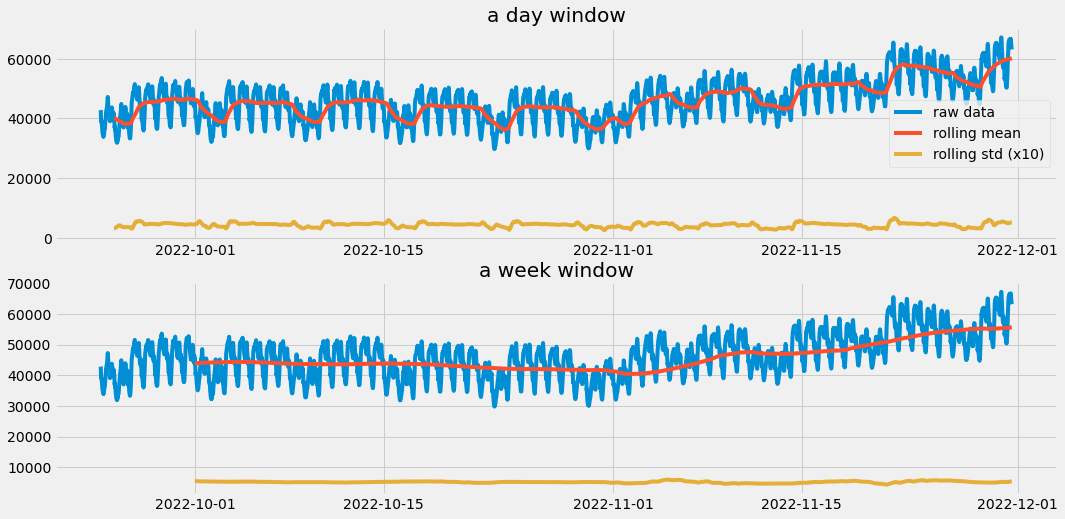

In [20]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=96).mean() 
    rolstd = pd.Series(timeseries).rolling(window=96).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('a day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=672).mean() 
    rolstd = pd.Series(timeseries).rolling(window=672).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('a week window')
    
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(data["Consommation (MW)"], 'raw data')


C:\Users\MEHDI CHAKROUN\AppData\Local\Temp\ipykernel_14684\1317098359.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date', 'Heure'], dtype='object')
  df_detrend = (data - data.rolling(window=672).mean()) / data.rolling(window=672).std()


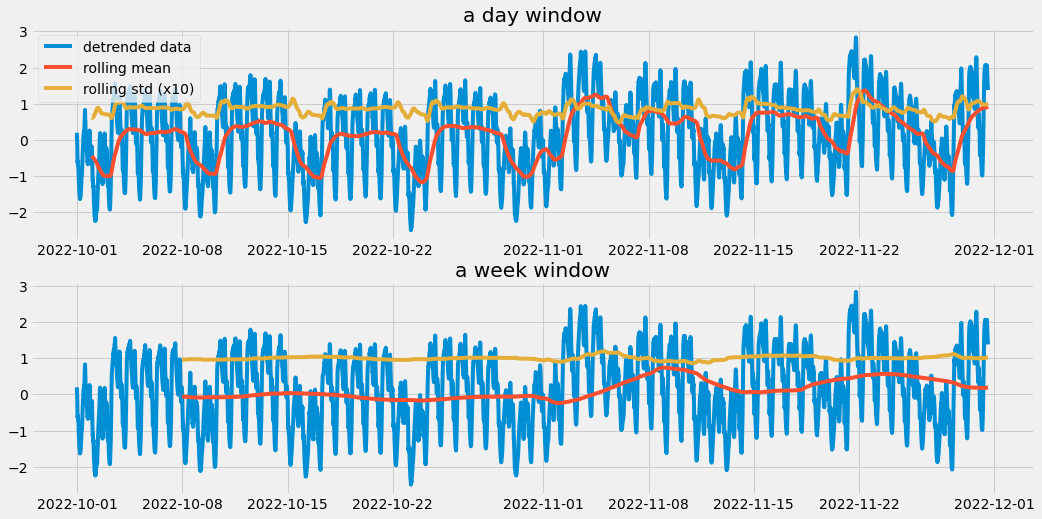

In [21]:
df_detrend = (data - data.rolling(window=672).mean()) / data.rolling(window=672).std()

analyze_stationarity(df_detrend["Consommation (MW)"].dropna(), 'detrended data')


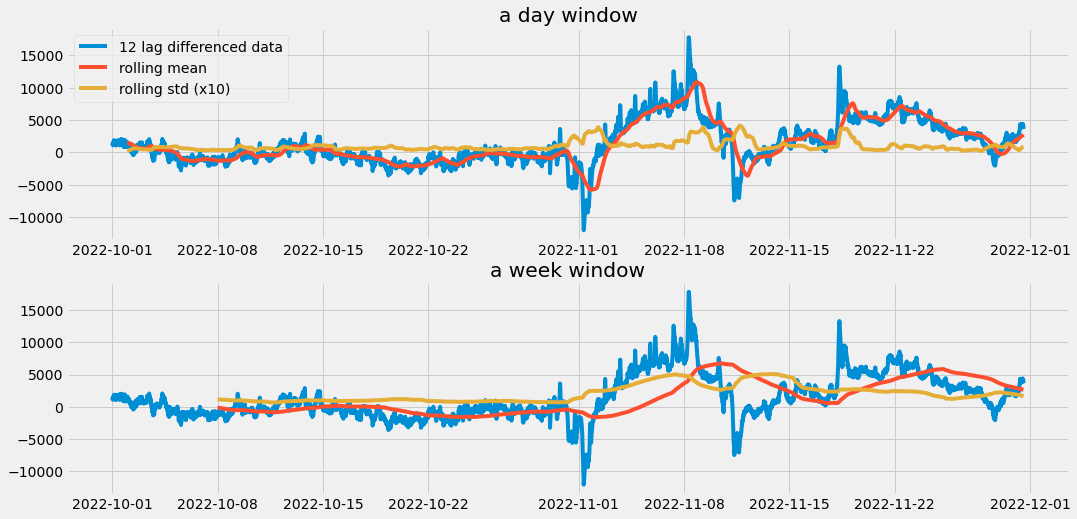

In [22]:
df_365lag =  data - data.shift(672)

analyze_stationarity(df_365lag["Consommation (MW)"].dropna(), '12 lag differenced data')

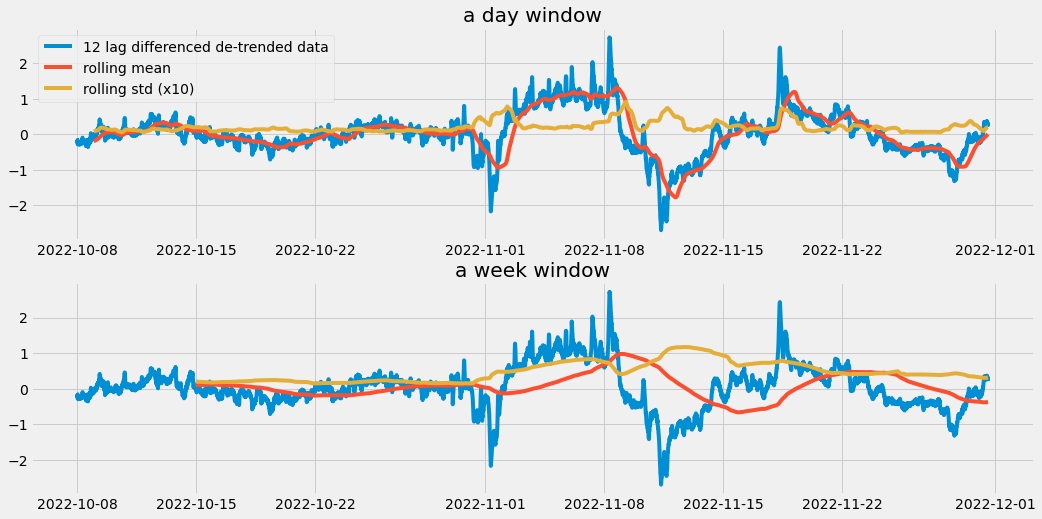

In [23]:
df_365lag_detrend =  df_detrend - df_detrend.shift(672)

analyze_stationarity(df_365lag_detrend["Consommation (MW)"].dropna(), '12 lag differenced de-trended data')

In [24]:
data_train=data.loc[data['Date'] < '2022-11-15'][["Consommation (MW)"]]
data_validation=data.loc[data['Date'] >= '2022-11-15'][["Consommation (MW)"]]
data_train= data_train["Consommation (MW)"].astype(float)
data_validation= data_validation["Consommation (MW)"].astype(float)
predict_date = len(data) - len(data_train)

C:\Users\MEHDI CHAKROUN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\Users\MEHDI CHAKROUN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=672 and a Box-Cox transformation 5024.44


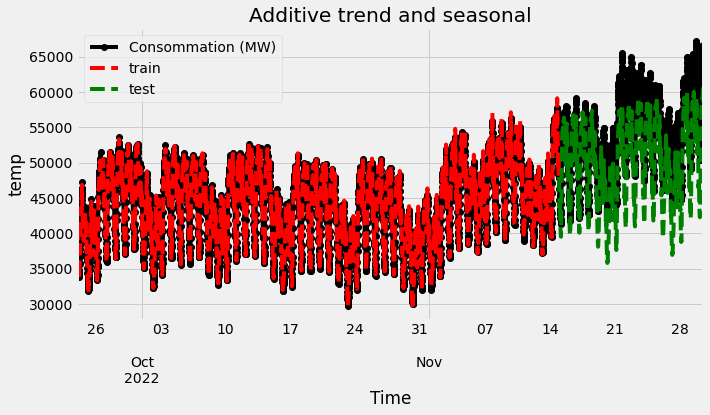

In [25]:

def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='mul', seasonal='mul', use_boxcox=True).fit()
    fcast1 = fit1.forecast(predict_date).rename('Multiplicative')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('temp')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()
    
holt_win_sea(data[["Consommation (MW)"]], data_train, data_validation, 672, predict_date)

###  FUNCTIONS 

In [26]:
data=pd.read_csv("eco2mix-national-tr.csv", sep=";")

def prepare_data(df_data, date_initiale='2022-09-24', source_conso="Consommation (MW)"):
    # Remove the unnecessary columns
    columns_to_drop=["Périmètre","Nature","Prévision J-1 (MW)","Prévision J (MW)", "Stockage batterie (MW)", "Déstockage batterie (MW)", "Eolien terrestre (MW)", "Eolien offshore (MW)"]
    df_data.drop(columns=columns_to_drop, inplace= True)
    # Remove duplicate values 
    df_data.drop_duplicates(subset=["Date - Heure"], inplace=True)
    # Remove rows containg empty values
    df_data.dropna(subset=["Date - Heure", "Consommation (MW)"], inplace = True)
    # Converting date column to datetime format and set time column as index
    df_data['Time'] = df_data[['Date', 'Heure']].agg(' '.join, axis=1)
    df_data["Time"]=pd.to_datetime(df_data["Time"])
    df_data["Date"]= pd.to_datetime(df_data["Date"])
    df_data["Heure"]=pd.to_datetime(df_data["Heure"])
    df_data.set_index("Time", inplace=True)
    df_data.drop(columns=["Date - Heure"], inplace= True)
    # Sorting df_data chronologically
    df_data=df_data.sort_index(ascending=True)
    df_data=df_data.loc[df_data['Date'] >= date_initiale]
    df_data=df_data[["Date","Heure",source_conso]]
    return df_data

def train_model(data, date_initiale='2022-09-24', source_conso="Consommation (MW)", data_validation='2022-11-24'): 
    data=prepare_data(df_data=data, date_initiale=date_initiale, source_conso=source_conso)
    # Split data into training and validation
    data_train=data.loc[data['Date'] < data_validation][[source_conso]]
    data_validation=data.loc[data['Date'] >= data_validation][[source_conso]]
    print(data_train.head())
    data_train= data_train[source_conso].astype(float)
    data_validation= data_validation[source_conso].astype(float)
    predict_date = len(data) - len(data_train)
    # Predict and print predictions
    holt_win_sea(data[source_conso], data_train, data_validation, 672, predict_date)
    return 

def predict_for_day(data, start_training='2022-09-24', end_training='2022-11-24',date_to_predict='2022-11-30',source_conso="Consommation (MW)", predict_period=672, duree_a_predire=672):
    transformed_data=prepare_data(df_data=data, date_initiale=start_training, source_conso=source_conso)
    # data into training 
    data_train=transformed_data.loc[transformed_data['Date'] <= end_training][[source_conso]]
    data_train= data_train[source_conso].astype(float)
    predict_date = duree_a_predire
    fit1 = ExponentialSmoothing(data_train, seasonal_periods=predict_period, trend='mul', seasonal='mul', use_boxcox=True).fit()
    fcast1 = fit1.forecast(predict_date).rename('Multiplicative')
    resultat=fcast1.loc[date_to_predict]
    return resultat
    

 ### EXECUTION 

TO predict the date, please read the csv file with pd.read and put valid dates (number of quarters between the date you want to predict and the validation date (training end) must be under 672) . 

In [44]:
data=pd.read_csv("eco2mix-national-tr.csv", sep=";")
resultat=predict_for_day(data, start_training='2022-09-24', end_training='2022-11-24',date_to_predict='2022-11-29',source_conso="Consommation (MW)", duree_a_predire=672)

C:\Users\MEHDI CHAKROUN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\Users\MEHDI CHAKROUN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [45]:
resultat.head(90)

2022-11-29 00:00:00   34932.47671052
2022-11-29 00:15:00   34610.08224784
2022-11-29 00:30:00   33420.40014133
2022-11-29 00:45:00   32289.82624513
2022-11-29 01:00:00   31860.59777419
                           ...      
2022-11-29 21:15:00   33344.83641662
2022-11-29 21:30:00   32626.98113224
2022-11-29 21:45:00   32060.66018230
2022-11-29 22:00:00   31635.95511449
2022-11-29 22:15:00   31635.60558488
Freq: 15T, Name: Multiplicative, Length: 90, dtype: float64